In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch import autograd
import math
from IPython.core.debugger import set_trace
from numpy.linalg import inv
from numpy.linalg import multi_dot as mdot
from collections import OrderedDict
from random import randint
from random import choice
import time
from random import shuffle
import gc
import os

In [2]:
from helpers import Trainer
from helpers import Logger
from helpers import Trial
from mibi_dataloader import MIBIData
import utils

In [3]:
main_dir = '/home/hazmat/Documents/brain_cohort/Alex_brain_cohort/multitiffs/'
train_dir = main_dir + ''
train_ds = MIBIData(folder=train_dir, crop=32, scale=1, stride=8)

['Point2.tiff', 'Point74.tiff', 'Point110.tiff', 'Point142.tiff', 'Point114.tiff', 'Point172.tiff', 'Point36.tiff', 'Point164.tiff', 'Point41.tiff', 'Point35.tiff', 'Point53.tiff', 'Point91.tiff', 'Point67.tiff', 'Point134.tiff', 'Point117.tiff', 'Point24.tiff', 'Point143.tiff', 'Point12.tiff', 'Point128.tiff', 'Point95.tiff', 'Point121.tiff', 'Point40.tiff', 'Point88.tiff', 'Point118.tiff', 'Point9.tiff', 'Point26.tiff', 'Point155.tiff', 'Point171.tiff', 'Point4.tiff', 'Point178.tiff', 'Point103.tiff', 'Point98.tiff', 'Point111.tiff', 'Point43.tiff', 'Point156.tiff', 'Point109.tiff', 'Point18.tiff', 'Point137.tiff', 'Point112.tiff', 'Point165.tiff', 'Point106.tiff', 'Point51.tiff', 'Point28.tiff', 'Point37.tiff', 'Point173.tiff', 'Point107.tiff', 'Point158.tiff', 'Point56.tiff', 'Point57.tiff', 'Point181.tiff', 'Point84.tiff', 'Point127.tiff', 'Point186.tiff', 'Point85.tiff', 'Point21.tiff', 'Point161.tiff', 'Point75.tiff', 'Point33.tiff', 'Point159.tiff', 'Point23.tiff', 'Point7.tiff

In [5]:
train_ds.images[1].shape

torch.Size([11, 512, 512])

In [6]:
import skimage

def blur_slice(tens, blur):
    return torch.tensor(skimage.filters.gaussian(tens.detach().cpu().numpy(), blur)).unsqueeze(0)

def blur_tensor(tens, blur):
    for i in range(tens.shape[0]):
        tens[i,:,:] = blur_slice(tens[i,:,:], blur)
    return tens
    
for i in range(len(train_ds.images)):
    idxs = (torch.sum(train_ds.images[i], dim=0, keepdim=True) == 0).repeat(train_ds.images[i].shape[0],1,1)
    train_ds.images[i] = blur_tensor(train_ds.images[i], 1)
    train_ds.images[i][idxs] = 0
    
train_ds.log_normalize()

In [7]:
class AutoColorLoss(nn.Module):
    def __init__(self, **kwargs):
        super(AutoColorLoss, self).__init__()
        self.recon_criterion = nn.MSELoss()
    
    def forward(self, **kwargs):
        x = kwargs['x']
        x_hat = kwargs['x_hat']
        loss = self.recon_criterion(x, x_hat)
        return {
            'loss': loss
        }


class SpatialBroadcaster(nn.Module):
    def __init__(self):
        super(SpatialBroadcaster, self).__init__()
        pass

    def make_grid(self, b, w, h):
        i = torch.tensor(np.linspace(-1, 1, w)).unsqueeze(0)
        j = torch.tensor(np.linspace(-1, 1, h)).unsqueeze(1)
        i = i.repeat(h, 1).unsqueeze(0).unsqueeze(0)
        j = j.repeat(1, w).unsqueeze(0).unsqueeze(0)
        i = i.repeat(b, 1, 1, 1)
        j = j.repeat(b, 1, 1, 1)
        coord = torch.cat((i, j), dim=1)
        return coord

    def forward(self, input):
        pass

    def broadcast(self, x, w, h):
        # x is assumed to have dimensions [batch, dim]
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = x.repeat(1, 1, w, h)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.broadcast = SpatialBroadcaster()
        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, padding=0, stride=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=0, stride=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=0, stride=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=0, stride=1)
        self.conv5 = nn.Conv2d(32, 4, kernel_size=1, padding=0, stride=1)

        self.relu = nn.ReLU()

    def forward(self, input):
        pass

    def decode(self, z, w, h):
        z = self.broadcast(z, w+8, h+8)
        z = self.relu(self.conv1(z))
        z = self.relu(self.conv2(z))
        z = self.relu(self.conv3(z))
        z = self.relu(self.conv4(z))
        z = self.conv5(z)

        x_hat = z[:, [i for i in range(0, z.shape[1]-1)], :, :]
        m_hat = z[:, [-1], :, :]

        return x_hat, m_hat


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        in_dim = 3
        self.conv1 = nn.Conv2d(in_dim + 1, 32, kernel_size=3, padding=0, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=0, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=0, stride=2)

        self.fc1 = nn.Linear(2*2*64, 256)
        self.fc2 = nn.Linear(256, 32)

        self.relu = nn.ReLU()

    def forward(self, input):
        pass

    def encode(self, x, m):
        z = torch.cat((x, m), dim=1)

        z = self.relu(self.conv1(z))
        z = self.relu(self.conv2(z))
        z = self.relu(self.conv3(z))
        z = self.relu(self.conv4(z))

        z = z.view(z.shape[0], -1)

        z = self.relu(self.fc1(z))
        z = self.relu(self.fc2(z))

        return z


# this is supposed to be some variety of U-Net
class Attender(nn.Module):
    def __init__(self):
        super(Attender, self).__init__()
        in_dim = 3
        self.conv1 = nn.Conv2d(in_dim + 1, 32, kernel_size=3, padding=0, stride=2, bias=False)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=0, stride=2, bias=False)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=0, stride=2, bias=False)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=0, stride=2, bias=False)

        self.fc1 = nn.Linear(2 * 2 * 32, 256)
        self.fc2 = nn.Linear(256, 32)

        self.relu = nn.ReLU()
        self.broadcast = SpatialBroadcaster()
        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, padding=0, stride=1, bias=False)
        self.conv6 = nn.conv2d(32, 1, kernel_size=1, padding=0, stride=1, bias=False)

    def forward(self, x, s):
        a = torch.cat((x, s), dim=1)
        a = self.relu(self.conv1(a))
        a = self.relu(self.conv2(a))
        a = self.relu(self.conv3(a))
        a = self.relu(self.conv4(a))

        a = a.view(a.shape[0], -1)
        a = self.relu(self.fc1(a))
        a = self.relu(self.fc2(a))

        a = self.broadcast(a, x.shape[2]+2, x.shape[3]+2)
        a = self.relu(self.conv5(a))
        a = self.conv6(a)

        return a


class MONet(nn.Module):
    def __init__(self):
        super(MONet, self).__init__()
        self.mse = nn.MSELoss()

        self.attender = Attender()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def init_s(self):
        pass

    def recur(self, x, s):
        # compute the mask
        a = self.attender(x, torch.log(s))
        m = s * a

        # compute latent
        z = self.encoder.encode(x, m)

        # reconstruct
        x_hat, m_hat = self.decoder.decode(z)

        # compute next scope image
        s = s * (1 - a)

        return x_hat, m_hat, m, s

    def forward(self, x):
        x_hat = torch.zeros_like(x)
        x_recon_loss = torch.tensor(0, requires_grad=True)
        m_recon_loss = torch.tensor(0, requires_grad=True)
        for k in range(5):
            x_k, m_k, m, s = self.recur(x, s)
            x_recon_loss += self.mse(x*m, x_k*m)
            m_recon_loss += self.mse(m, m_k)
            x_hat += m*x_k
        return x_hat, x_recon_loss, m_recon_loss


class AutoColor(nn.Module):
    def __init__(self, **kwargs):
        super(AutoColor, self).__init__()
        in_dim = kwargs['in_dim']
        self.start_epoch = 0
        self.config = dict()
        self.m = torch.tensor(0)
        self.noise_std = .01
        self.encoder = nn.Sequential(
            nn.Conv2d(in_dim, 8, 1),
            nn.BatchNorm2d(8),
            nn.PReLU(),
            nn.Conv2d(8, 5, 1),
            nn.BatchNorm2d(5),
            nn.PReLU(),
            nn.Conv2d(5, 3, 1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(3, 5, 1),
            nn.PReLU(),
            nn.Conv2d(5, 8, 1),
            nn.PReLU(),
            nn.Conv2d(8, in_dim, 1),
            nn.PReLU()
        )

    def forward(self, **kwargs):
        x = kwargs['x']
        z = self.encode(x)
        x_hat = self.decode(z)
        return {
            'x_hat': x_hat
        }

    def set_noise_std(self, x):
        pass
    
    def set_noise(self, new_noise):
        self.noise_std = new_noise
  
    def encode(self, x):
        self.m = self.mask(x)
        return self.m * self.encoder(x)

    def decode(self, z):
        x_hat = self.decoder(z)
        return self.m * (x_hat + self.noise_std * torch.randn_like(x_hat))
  
    def mask(self, x):
        m = torch.sum(x, dim=1, keepdim=True)
        m = (m != 0).float()
        return m
  
    def save_model(self, path, filename):
        model = {
          'model': AutoColor,
          'config': self.config,
          'state_dict': self.state_dict(),
        }
        torch.save(model, path + filename)

    def load(self, apath, file='model_latest.pt', resume=-1):
        load_from = None
        kwargs = {}
        if resume == -1:
          load_from = torch.load(os.path.join(apath, file), **kwargs)
        if load_from:
          self.load_state_dict(load_from, strict=False)
      
    @staticmethod
    def load_model(path, filename):
        checkpoint = torch.load(path + filename)
        model = checkpoint['model'](**checkpoint['config'])
        model.load_state_dict(checkpoint['state_dict'])
        return model

In [8]:
autocolor = AutoColor(in_dim=11)

In [9]:
autocolor_logger = Logger(['loss'])

In [10]:
autocolor_trainer = Trainer()

In [11]:
autocolor_train_args = dict()
autocolor_train_args['lr'] = 0.01
autocolor_train_args['batch_size'] = 200
autocolor_train_args['epochs'] = 20
autocolor_train_args['report'] = 5
autocolor_train_args['crop'] = 8
autocolor_train_args['restart'] = True
autocolor_train_args['epoch_frac'] = 1

train_ds.set_crop(autocolor_train_args['crop'])

3969


In [12]:
autocolor.set_noise(0.01)

autocolor.cuda()
autocolor.train()
autocolor_train_args['continue'] = False

autocolor_criterion = AutoColorLoss()
autocolor_trainer.train(autocolor, train_ds, autocolor_criterion, autocolor_logger, **autocolor_train_args)

3969
3969

Epoch:0 > < 0.08337970760728335                                      
    Minibatch:5/3730 > < loss: 0.08351, noise: 0.18996,       

/home/hazmat/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type AutoColor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:1 > < 0.075118849422513                                      
Epoch:2 > < 0.07258031465932127                                      
Epoch:3 > < 0.07190924236905478                                      
Epoch:4 > < 0.07104568327739635                                      
Epoch:5 > < 0.07063633863372235                                      
Epoch:6 > < 0.07012845341805318                                      
Epoch:7 > < 0.0693014704899478                                      
Epoch:8 > < 0.06872101349221797                                      
Epoch:9 > < 0.06850890450818768                                      
Epoch:10 > < 0.06825962172117055                                      
Epoch:11 > < 0.06821285832883046                                      
Epoch:12 > < 0.06810985972290863                                      
Epoch:13 > < 0.06810985924551219                                      
Epoch:14 > < 0.06798358474915532                                      
Epoch:15 > < 0.067

1794.8509500026703

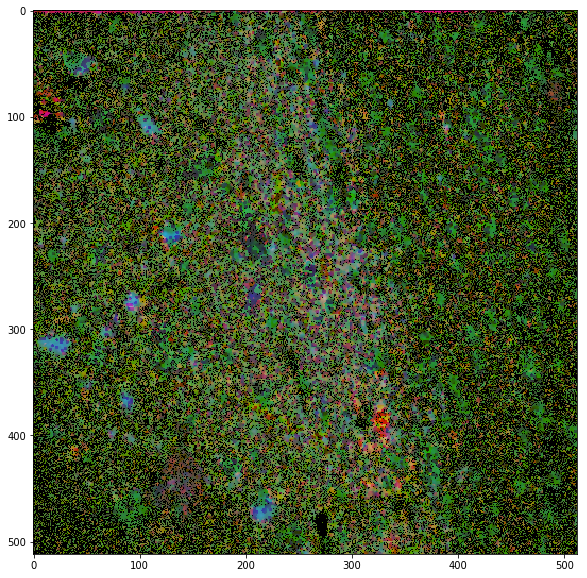

In [13]:
x = train_ds.images[180].unsqueeze(0).cuda()

autocolor.eval()
z = autocolor.encode(x)[0,:,:,:].transpose(0,1).transpose(1,2).detach().cpu()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.imshow(z[:,:,:])
plt.show()

In [ ]:
z.shape

In [ ]:
m = (torch.sum(z, dim=2, keepdim=True) !=0 ).float()

In [ ]:
y = m*z

In [ ]:
import scipy.misc

for i in range(len(train_ds.images)):
    name = train_ds.source[i]
    x = train_ds.images[i].unsqueeze(0).cuda()
    autocolor.eval()
    img = autocolor.encode(x)[0,:,:,:].transpose(0,1).transpose(1,2).detach().cpu()
    scipy.misc.imsave('/home/hazmat/Documents/brain_cohort/Alex_brain_cohort/synthetic/' + name, img.numpy())

In [ ]:
print(len(train_ds.images))